## Kaggle Contest on *Observing Dark World*

A personal motivation for learning Bayesian methods was trying to piece together the winning solution to Kaggle's [*Observing Dark Worlds*](http://www.kaggle.com/c/DarkWorlds) contest. From the contest's website:



>There is more to the Universe than meets the eye. Out in the cosmos exists a form of matter that outnumbers the stuff we can see by almost 7 to 1, and we don’t know what it is. What we do know is that it does not emit or absorb light, so we call it Dark Matter. Such a vast amount of aggregated matter does not go unnoticed. In fact we observe that this stuff aggregates and forms massive structures called Dark Matter Halos. Although dark, it warps and bends spacetime such that any light from a background galaxy which passes close to the Dark Matter will have its path altered and changed. This bending causes the galaxy to appear as an ellipse in the sky.

<img src="http://timsalimans.com/wp-content/uploads/2012/12/dm.jpg">


The contest required predictions about where dark matter was likely to be. The winner, [Tim Salimans](http://timsalimans.com/), used Bayesian inference to find the best locations for the halos (interestingly, the second-place winner also used Bayesian inference). With Tim's permission, we provided his solution [1] here:

1. Construct a prior distribution for the halo positions $p(x)$, i.e. formulate our expectations about the halo positions before looking at the data.
2. Construct a probabilistic model for the data (observed ellipticities of the galaxies) given the positions of the dark matter halos: $p(e | x)$.
3. Use Bayes’ rule to get the posterior distribution of the halo positions, i.e. use to the data to guess where the dark matter halos might be.
4. Minimize the expected loss with respect to the posterior distribution over the predictions for the halo positions: $\hat{x} = \arg \min_{\text{prediction} } E_{p(x|e)}[ L( \text{prediction}, x) ]$ , i.e. tune our predictions to be as good as possible for the given error metric.

The loss function in this problem is very complicated. For the very determined, the loss function is contained in the file DarkWorldsMetric.py in the parent folder. Though I suggest not reading it all, suffice to say the loss function is about 160 lines of code &mdash; not something that can be written down in a single mathematical line. The loss function attempts to measure the accuracy of prediction, in a Euclidean distance sense, such that no shift-bias is present. More details can be found on the metric's [main page](http://www.kaggle.com/c/DarkWorlds/details/evaluation). 

We will attempt to implement Tim's winning solution using [Tensorflow Probability](https://medium.com/tensorflow/introducing-tensorflow-probability-dca4c304e245) (full whitepaper [here](https://arxiv.org/pdf/1711.10604.pdf)) and our knowledge of loss functions.

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
from utils import *

W0826 15:30:30.312350 4715427264 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
reset_sess()

import wget

# Downloading the zip file containing the Galaxy Data
url1 = 'https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/data.zip?raw=true'
filename1 = wget.download(url1)
filename1

'data.zip'

In [7]:
!unzip -q data.zip -d data

We also want to import the data files and Loss functions specific to this Kaggle Competition. You can download the files directly from the [Observing Dark Worlds competition's Data page](https://www.kaggle.com/c/DarkWorlds/data) or, if you already have a Kaggle account, install the [Kaggle API](https://github.com/Kaggle/kaggle-api) and run the following terminal command:

```
kaggle competitions download -c DarkWorlds
```

And once the competition information is available locally, we can simply unzip the data.

One last thing to set up is the function we use for plotting galaxies from the files, which we define here:

#### Defining our galaxy-plotting function

In [8]:
reset_sess()

def draw_sky(galaxies):
    """
    From a given file of galaxy data,
    plot the shapes and positions of 
    galaxies.
    
    Args:
      galaxies: 4-column, float32 Numpy array
      containing x-coordinates, y-coordinates,
      and the two axes of ellipcity.
    Returns:
      fig: image of galaxy plot
    """
    size_multiplier = 45
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        g = galaxies[i, :]
        x, y = g[0], g[1]
        d = np.sqrt(g[2] ** 2 + g[3] **2)
        a = 1.0 / (1 - d)
        b = 1.0 / (1 + d)
        theta = np.degrees(np.arctan2(g[3], g[2])*0.5 )
        
        ax.add_patch(Ellipse(xy=(x, y), width=size_multiplier * a, height=size_multiplier * b,
                            angle=theta))
    ax.autoscale_view(tight=True)
    
    return fig

### Examining Our Data

The dataset is actually 300 separate files, each representing a sky. In each file, or sky, are between 300 and 720 galaxies. Each galaxy has an $x$ and $y$ position associated with it, ranging from 0 to 4200, and measures of ellipticity: $e_1$ and $e_2$. Information about what these measures mean can be found [here](https://www.kaggle.com/c/DarkWorlds/details/an-introduction-to-ellipticity), but for our purposes it does not matter besides for visualization purposes. Thus a typical sky might look like the following:

In [9]:
reset_sess()

n_sky = 3
data = np.genfromtxt('data/Train_Skies/Train_Skies/Training_Sky%d.csv' % (n_sky),
                    dtype=np.float32,
                    skip_header=1,
                    delimiter=',',
                    usecols=[1, 2, 3, 4])

galaxy_positions = np.array(data[:, :2], dtype=np.float32)
gal_ellipticities = np.array(data[:, 2:], dtype=np.float32)
ellipticity_mean = np.mean(data[:, 2:], axis=0)
ellipticity_stddev = np.std(data[:, 2:], axis=0)
num_galaxies = np.array(galaxy_positions).shape[0]

print("Data on galaxies in sky %d." % n_sky)
print("position_x, position_y, e_1, e_2")
print(data[:3])
print('Number of galaxies: ', num_galaxies)
print("e_1 & e_2 mean: ", ellipticity_mean)
print("e_1 & e_2 std_dev: ", ellipticity_stddev)

Data on galaxies in sky 3.
position_x, position_y, e_1, e_2
[[ 1.62690e+02  1.60006e+03  1.14664e-01 -1.90326e-01]
 [ 2.27228e+03  5.40040e+02  6.23555e-01  2.14979e-01]
 [ 3.55364e+03  2.69771e+03  2.83527e-01 -3.01870e-01]]
Number of galaxies:  578
e_1 & e_2 mean:  [ 0.01398942 -0.00522833]
e_1 & e_2 std_dev:  [0.23272723 0.22050022]


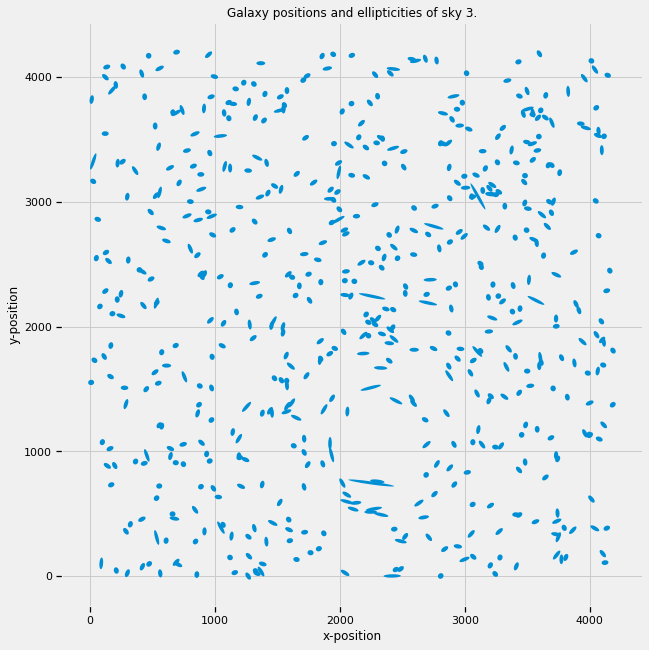

In [10]:
fig = draw_sky(data)
plt.title('Galaxy positions and ellipticities of sky %d.' % n_sky)
plt.xlabel('x-position')
plt.ylabel('y-position');

### Priors
Each sky has one, two or three dark matter halos in it. Tim's solution details that his prior distribution of halo positions was uniform, i.e.

$$
\begin{aligned}
x_i & \sim \mathrm{Uniform}(0, 4200) \\
y_i & \sim \mathrm{Uniform}(0, 4200),\,\, i=1, 2, 3
\end{aligned}
$$
Tim and other competitors noted that most skies had one large halo and other halos, if present were much smaller. Larger halos, having more mass, will influence the surrounding galaxies more. He decided that the large halos would have a mass distributed as a *log*-uniform random variable between 40 and 180, i.e.

$$
m_{\mathrm{large}} = \log \mathrm{Uniform}(40, 180)
$$

and in Tensorflow Probability,
```python
# Log-Uniform distribution
mass_large = tfd.TransformedDistribution(
    distribution=tfd.Uniform(name='exp_mass_large', low=40., high=180.),
    bijector=tfb.Exp())
```
(This is what we mean when we say *log*-uniform).
For smaller galaxies, Tim set the mass to be the logarithm of 20. Why did Tim not create a prior for the smaller mass, nor treat it as an unknown? I believe this decision was made to speed up convergence of the algorithm. This is not too restrictive, as by construction the smaller halos have less influence on the galaxies.

Tim logically assumed that the ellipticity of each galaxy is dependent on the position of the halos, the distance between the galaxy and halo, and the mass of the halos. Thus the vector of ellipticity of each galaxy, $\mathbf{e}_i$, are *children* variables of the vector of halo positions $(\mathbf{x}, \mathbf{y})$, distance (which we will formalize), and halo masses.

Tim conceived a relationship to connect positions and ellipticity by reading literature and forum posts. He supposed the following was a reasonable relationship:

$$
e_i|(\mathbf{x}, \mathbf{y}) \sim \mathrm{Normal}(\sum_{j=\mathrm{halo positions}}d_{i,j}m_j f(r_{i,j}), \sigma^2)
$$

where $d_{i,j}$ is the *tangential direction* (the direction in which halo $j$ bends the light of galaxy $i$), $m_j$ is the mass of halo $j$, $f(r_{i,j})$ is a *decreasing function* of the Euclidean distance between halo $j$ and galaxy $i$.

The variance, or $\sigma^2$, was simply estimated to be 0.05 from eyeballing the data. This means the standard deviation (sd) of the measurements of $e_i$ for the full range of $i$ works out to be approximately 0.223607.

Tim's function $f$ was defined:

$$
f(r_{i,j}) = \frac{1}{\min(r_{i,j}, 240)}
$$
for large halos, and for small halos
$$
f(r_{i,j}) = \frac{1}{\min(r_{i,j}, 70)}
$$
This fully bridges our observations and unknown. This model is incredibly simple, and Tim mentions this simplicity was purposefully designed: it prevents the model from overfitting.

### Training & Tensorflow implementation
For each sky, we run our Bayesian model to find the posteriors for the halo positions - we ignore the (known) halo position. This is slightly different than perhaps traditional approaches to Kaggle competitions, where this model uses no data from other skies nor the known halo location. That does not mean other data are not necessary - in fact, the model was created by comparing different skies.

**Constructing a prior distribution for the halo positions $p(x)$, i.e. formulate our expectations about the halo positions before looking at the data.**

When constructing our prior and likelihood distributions, we are going to use these to set up a loss function that is very similar to that of a [variational autoencoder](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py) (though a much lower dimension one).

In [11]:
def euclidean_distance(x, y):
    """
    Calculates the euclidean distance between point x and point y.
    
    Args:
      x: a Tensorflow tensor for element-wise 
      calculation
      y: a Tensorflow tensor for element-wise
      calculation
    Returns:
      a Tensor containing the euclidean 
      distance between x and y
    """
    return tf.sqrt(tf.reduce_sum(tf.squared_difference(x, y), axis=1), name='euclid_dist')


def f_distance(gxy_pos, halo_pos, c):
    """
    Provides our element-wise maximum as in NumPy,
    but instead for Tensorflow tensors
    
    Args:
      gxy_pos: a 2-D numpy array of observed galaxy 
        positions
      halo_pos: a 2-D numpy array with halo positions
      c: a scalar of shape order 0
      
    Returns:
      Maximum of either the euclidean distance of gxy_pos
      & halo_pos, or the constant c.
    """
    return tf.maximum(euclidean_distance(gxy_pos, halo_pos), c, name='f_dist')[:, None]

def tangential_distance(glxy_position, halo_position):
    """
    Calculates the tangential distance between 
    coordinates glxy_position & halo_position.
    
    Args:
      glxy_position: a 2-d numpy array of observed galaxy 
        positions
      halo_positions: a 2-d numpy array with halo positions
      
    Returns:
      vectors with direction of dominant halo.
    """
    x_delta, y_delta = tf.unstack(
        glxy_position - halo_position, num=2, axis=-1)
    angle = 2. * tf.atan(y_delta / x_delta)
    return tf.stack([-tf.cos(angle), -tf.sin(angle)], axis=-1, name='tan_dist')

In [12]:
def posterior_log_prob(mass_large, halo_pos):
    """
    Our posterior log probability, as a function of states
    Closure over: data
    
    Args:
      mass_large: scalar of halo mass, taken from state
      halo_pos: tensor of halo position(s), taken from state
    Returns:
      scalar sum of log probabilities
    """
    rv_mass_large = tfd.Uniform(name='rv_mass_large', low=40., high=180.)
    
    # Set the random size of the halo's mass (the big halo for now)
    # We use tfd.Independent to change the batch and event shapes
    rv_halo_pos = tfd.Independent(tfd.Uniform(
                                    low=[0., 0.],
                                    high=[4200., 4200.]),
                                 reinterpreted_batch_ndims=1, name='rv_halo_position')
    ellpty_mvn_loc = (mass_large /
                      f_distance(data[:, :2], halo_pos, 240.) *
                      tangential_distance(data[:, :2], halo_pos))
    ellpty = tfd.MultivariateNormalDiag(loc=ellpty_mvn_loc, 
                        scale_diag=[0.223607, 0.223607],
                        name='ellpty')
    
    return (tf.reduce_sum(ellpty.log_prob(data[:, 2:]), axis=0) + 
            rv_halo_pos.log_prob(halo_pos) + 
            rv_mass_large.log_prob(mass_large))

**Constructing a probabilistic model for the data (observed ellipticities of the galaxies) given the positions of the dark matter halos:** $p(e|x)$

Given data, we use a Metropolis Random Walk (MRW) Markove chain Monte Carlo method to calculate the precise posterior distribution over the model's parameters. It is possible to use Hamiltonian Monte Carlo (HMC) for problems like this, but Metropolis is more appropriate for this case due to its comparative simplicity.

Tim's model gives us an approximate posterior to start with. That is, we assume the posterior must be proportional to the normal distribution of distances inferred from galaxy ellipcities.

In [16]:
reset_sess()

In [17]:
# Inferring the posterior distribution

number_of_steps = 5000
burnin = 4500

# Set the chain's start state.
initial_chain_state = [
    tf.fill([1], 80., name='init_mass_large'),
    tf.fill([1, 2], 2100., name='init_halo_pos')
]

# Since HMC operates over unconstrained space, we need to transform the 
# samples to they live in real space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity()
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: posterior_log_prob(*args)

# Initialize the step size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.06, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )
    
# Defining the HMC
hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=6,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
            num_adaptation_steps=int(burnin*0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors
    )

# Sampling from the chain.
[
    mass_large,
    halo_pos
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc
)

W0826 18:11:34.838189 4715427264 deprecation.py:323] From /Users/sueliu/projects/personal-study/Bayesian-Methods-for-Hackers/.venv/lib/python3.7/site-packages/tensorflow_probability/python/distributions/uniform.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
# Some of the steps of the MCMC will involve just getting close to where the right answers are
# so we get the samples random walk, and cut off the trial (or `burn_in`) steps    
burned_halo_position_samples = tf.stack(tf.map_fn(lambda x: x[0], halo_pos), axis=0)[burnin:]
    
# we'll take the mean and standard deviations of the samples to put
# together the approximate posterior distribution for the large halo    
halo_mean = tf.reduce_mean(burned_halo_position_samples, axis=0)
halo_stdev = tf.sqrt(
    tf.reduce_mean(tf.squared_difference(burned_halo_position_samples, halo_mean),
                  axis=0))

approx_posterior = tfd.MultivariateNormalDiag(loc=halo_mean, scale_diag=halo_stdev, name='approx_posterior')

approx_post_samples_num = 5000

# Getting 50,000 samples from the approximate posterior distribution
posterior_predictive_samples = approx_posterior.sample(
    sample_shape=approx_post_samples_num)

# Initializing our variables
init_g = tf.global_variables_initializer()

In [19]:
# Running the Initializer on our model
evaluate(init_g)

# performing our computations
[
    posterior_predictive_samples_,
    kernel_results_,
] = evaluate([
    posterior_predictive_samples,
    kernel_results,
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))
print("posterior_predictive_samples_ value: \n {}".format(
    posterior_predictive_samples_))

acceptance rate: 0.778
final step size: 19.642236709594727
posterior_predictive_samples_ value: 
 [[2323.6821 1155.2158]
 [2264.5676 1106.5172]
 [2333.8315 1079.507 ]
 ...
 [2325.3835 1134.1042]
 [2336.2405 1142.0775]
 [2354.0596 1113.1797]]


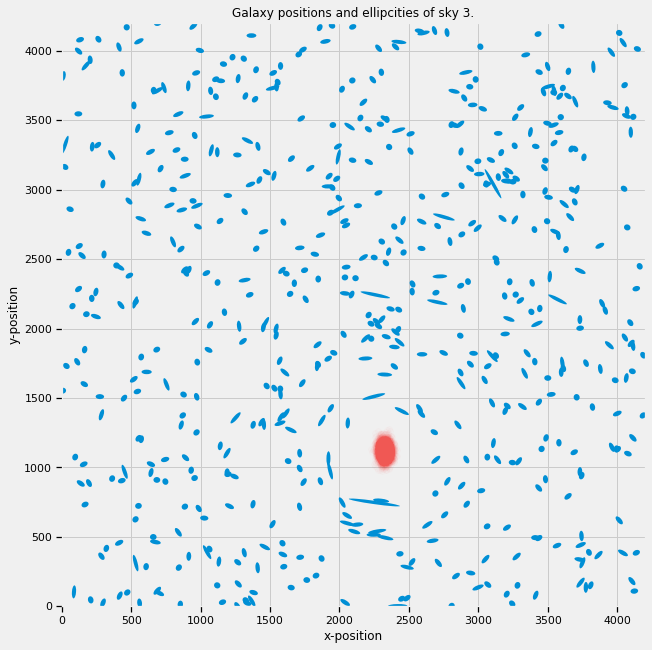

In [20]:
t = posterior_predictive_samples_.reshape(5000,2)

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "#F15854") # Red
plt.xlim(0, 4200)
plt.ylim(0, 4200);

Associated with eacy sky is another data point, located in `.data/Training_halos.csv` that holds the locations of up to three dark matter halos contained in the sky. For example, the night sky we trained on has halo locations:

In [21]:
halo_data = np.genfromtxt('data/Training_halos.csv',
                         delimiter=',',
                         usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9],
                         skip_header=1)
print(halo_data[n_sky])

[1.00000e+00 1.40861e+03 1.68586e+03 1.40861e+03 1.68586e+03 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]


True halo location: 1408.61 1685.86


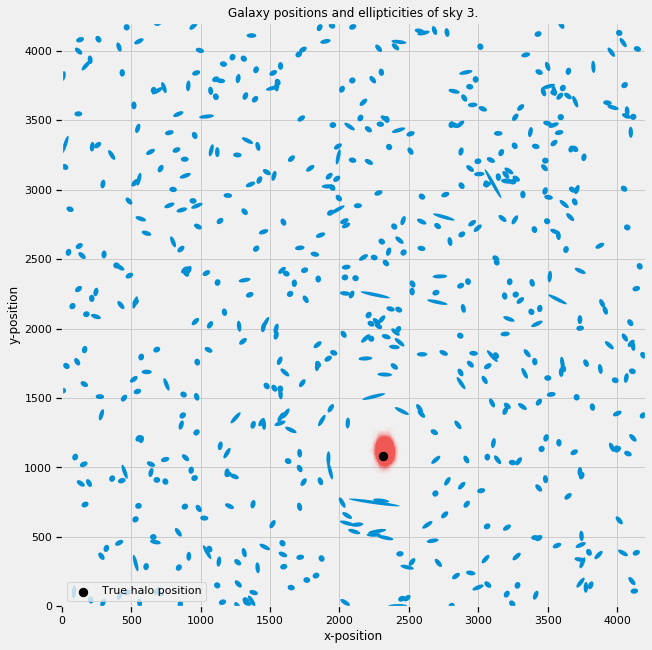

In [22]:
fig = draw_sky(data)
plt.title('Galaxy positions and ellipticities of sky %d.' % n_sky)
plt.xlabel('x-position')
plt.ylabel('y-position')
plt.scatter(t[:,0], t[:, 1], alpha=0.015, c='#F15854')
plt.scatter(halo_data[n_sky-1][3], halo_data[n_sky-1][4],
           label='True halo position',
           c='k', s=70)
plt.legend(scatterpoints=1, loc='lower left')
plt.xlim(0, 4200)
plt.ylim(0, 4200);

print('True halo location:', halo_data[n_sky][3], halo_data[n_sky][4])

In [23]:
mean_posterior = t.mean(axis=0).reshape(1, 2)
print('Mean posterior: \n {}'.format(mean_posterior[0]))

Mean posterior: 
 [2325.1218 1120.7917]


In [25]:
reset_sess()

import wget
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter5_LossFunctions/DarkWorldsMetric.py'
filename = wget.download(url)
filename

'DarkWorldsMetric (1).py'

In [28]:
from DarkWorldsMetric import main_score

halo_data_sub = halo_data[n_sky-1]

nhalo_all  = halo_data_sub[0].reshape(1, 1)
x_true_all = halo_data_sub[3].reshape(1, 1)
y_true_all = halo_data_sub[4].reshape(1, 1)
x_ref_all  = halo_data_sub[1].reshape(1, 1)
y_ref_all  = halo_data_sub[2].reshape(1, 1)
sky_prediction = mean_posterior

print('Using the mean:', sky_prediction[0])
main_score(nhalo_all, x_true_all, y_true_all, x_ref_all, y_ref_all, sky_prediction)

random_guess = tfd.Independent(tfd.Uniform(
                                           low=[0., 0.],
                                           high=[4200., 4200.]),
                              reinterpreted_batch_ndims=1,
                              name='rv_halo_position').sample()
random_guess_ = evaluate([random_guess])

print('\n Using a random location:', random_guess_[0])
main_score(nhalo_all, x_true_all, y_true_all, x_ref_all, y_ref_all, random_guess_)

Using the mean: [2325.1218 1120.7917]
Your average distance in pixels you are away from the true halo is 39.949356785340605
Your average angular vector is 1.0
Your score for the training data is 1.0399493567853406

 Using a random location: [3379.047  1987.7352]
Your average distance in pixels you are away from the true halo is 1396.7762342665408
Your average angular vector is 1.0
Your score for the training data is 2.396776234266541


2.396776234266541

In [29]:
reset_sess()     # Our custom function from before

n_sky = 215             #choosing a file/sky to examine.
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = np.float32,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])
              # It's handy to specify the data type beforehand

galaxy_positions = np.array(data[:, :2], dtype=np.float32)
gal_ellipticities = np.array(data[:, 2:], dtype=np.float32)
ellipticity_mean = np.mean(data[:, 2:], axis=0)
ellipticity_stddev = np.std(data[:, 2:], axis=0)
num_galaxies = np.array(galaxy_positions).shape[0]

print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])
print("Number of Galaxies: ", num_galaxies)
print("e_1 & e_2 mean: ", ellipticity_mean)
print("e_1 & e_2 std_dev: ", ellipticity_stddev)


Data on galaxies in sky 215.
position_x, position_y, e_1, e_2 
[[ 3.90340e+03  1.38480e+03 -4.93760e-02  1.73814e-01]
 [ 1.75626e+03  1.64510e+03  4.09440e-02  1.90665e-01]
 [ 3.81832e+03  3.18108e+03  1.97530e-01 -2.10599e-01]]
Number of Galaxies:  449
e_1 & e_2 mean:  [ 0.01484613 -0.02457484]
e_1 & e_2 std_dev:  [0.20280695 0.20415685]
